# Classify Name With RNN using Pytorch

In this notebook we will make a classify that classify the language of the given text using Recurrent Neural Network (RNN)

## Setup Device

In [1]:
import torch

In [2]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

In [3]:
torch.set_default_device(device)
print("Using device: ", torch.get_default_device())

Using device:  cpu


# Data Loading

In [4]:
import pandas as pd

In [5]:
data_path = "language-classified-romanized_sentences.csv"

In [6]:
df = pd.read_csv(data_path)

In [7]:
df.head()

,Unnamed: 0,text,language
0,0,"""Five newly appointed ministers of the Bagmati...",eng
1,1,Province Chief Dipak Prasad Devkota administe...,eng
2,2,Chief Minister Indra Bahadur Baniya appointed...,eng
3,3,Bade from Kavre has been assigned to the Mini...,eng
4,4,"On August 5, Chief Minister Baniya had appoin...",eng


In [8]:
df["language"].value_counts()

language
eng              3584
nep              1478
romanized_nep    1478
Name: count, dtype: int64

In [9]:
df[df["language"] == "nep"]["text"].tolist()[:10]

['"तुर्कमेनिस्तानको अवाजामा सम्पन्न भूपरिवेष्ठित विकासशील राष्ट्रहरूको तेस्रो संयुक्त राष्ट्रसङ्घीय सम्मेलनमा सहभागी भइ प्रधानमन्त्री केपी शर्मा ओली शुक्रबार स्वदेश फर्कँदै हुनुहुन्छ ',
 ' उहाँ भर्खरै तुर्कमनेबासी अन्तर्राष्ट्रिय विमानस्थलबाट दुबई प्रस्थान गर्नुभएको छ ',
 'प्रधानमन्त्री ओलीलाई विमानस्थलमा स्थानीय समय अनुसार बिहान ८ः३० बजे तुर्कमेनिस्तान सरकारका उपप्रधानमन्त्री रहसित मेरेडोभले बिदाइ गर्नुभयो ',
 ' प्रधानमन्त्री ओली दुबई हुँदै आज राति ११ः५ बजे नेपाल आइपुग्नुहुने कार्यक्रम रहेको छ ',
 '"मधेश प्रदेशका खेलकुद तथा समाजकल्याण मन्त्री प्रमोद जयसवालले मधेश प्रदेशको मानव सूचकाङ्कको अवस्था ठिक नरहेको भन्दै सुधारका लागि सबैको साझा प्रयास आवश्यक रहेको बताउनुभएको छ ',
 'मधेश प्रदेशको राजधानी जनकपुरधाममा बिहीबार संयुक्त राष्ट्रसङ्घीय जनसङ्ख्याकोष (यूएनएफपिए)को अर्धवार्षिक समिक्षा कार्यक्रममा बोल्दै उहाँले यस्तो बताउनुभएको हो ',
 ' उहाँले भौगोलिक दृष्टिकोणले सुगम रहेको मधेश प्रदेशको मानव सूचकाङ्कको अवस्था हेर्दा नाक खुम्चियाएर बस्नु पर्ने अवस्था रहेको भन्दै यस अवस्थाको सुधार गर्नु हाम

# Data Cleaning

In [10]:
import string
import unicodedata

In [11]:
string.ascii_letters 

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [12]:
def get_unique_letters(sentences_list):
    chars = []
    for sent in sentences_list:
        chars.extend(list(sent))
        chars = list(set(chars))
    return sorted(chars)

In [13]:
nep_sentences = df[df["language"] == "nep"]["text"].tolist()
eng_sentences = df[df["language"] == "eng"]["text"].tolist()
romanized_sentences = df[df["language"] == "romanized_nep"]["text"].tolist()

In [14]:
nep_vocab = get_unique_letters(nep_sentences)
print(nep_vocab)

[' ', '"', '(', ')', ',', '-', '.', '/', ':', '\xa0', '¥', '÷', 'ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'े', 'ै', 'ो', 'ौ', '्', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९', '\u200d', '–', '‘', '’', '“', '”', '\u2028', '\u202f']


In [15]:
eng_vocab = get_unique_letters(eng_sentences)
print(eng_vocab)

[' ', '"', '$', '%', '(', ')', '*', '+', ',', '-', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', '°', 'ó', '–', '—', '‘', '’', '“', '”', '…', '′']


In [16]:
romanized_vocab = get_unique_letters(romanized_sentences)
print(romanized_vocab)

[' ', '"', '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '^', '_', 'a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'y', '~', '\xa0', '¥', '÷', '–', '‘', '’', '“', '”', '\u2028', '\u202f']


In [17]:
VOCAB = sorted(list(set(nep_vocab + eng_vocab + romanized_vocab)))
print(VOCAB)

[' ', '"', '$', '%', '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '\xa0', '¥', '°', 'ó', '÷', 'ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'े', 'ै', 'ो', 'ौ', '्', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९', '\u200d', '–', '—', '‘', '’', '“', '”', '…', '\u2028', '\u202f', '′']


In [18]:
VOCAB = [' ', '"', '$', '%', '(', ')', '*', '+', ',', '-', '.', '/', 
 '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
 'y', 'z', '°', 'ó', '÷', 'ँ', 'ं', 'ः', 'अ', 'आ',
 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ',
 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ',
 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श',
 'ष', 'स', 'ह', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'े', 'ै', 'ो',
 'ौ', '्', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९',
 '—', '‘', '’', '“', '”', '′']
len(VOCAB)

125

In [19]:
OOV = "*"
VOCAB += OOV
print(VOCAB)

[' ', '"', '$', '%', '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '°', 'ó', '÷', 'ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'े', 'ै', 'ो', 'ौ', '्', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९', '—', '‘', '’', '“', '”', '′', '*']


## Turn Words into Tensors

In [20]:
def char_to_index(char):
    if char in VOCAB:
        return VOCAB.index(char)
    return VOCAB.index(OOV)

def sentence_to_tensor(sentence):
    time_stamp = len(sentence)
    batch_size = 1
    vocab_size = len(VOCAB)
    tensor = torch.zeros(time_stamp, batch_size, vocab_size)
    for i, char in enumerate(sentence): #one-hot-encoding of the sentence
        tensor[i][0][char_to_index(char)] = 1
    return tensor

In [21]:
char_to_index("a")

22

In [22]:
sentence_to_tensor("ap")

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0

## Build DataLoader

In [23]:
from torch.utils.data import Dataset

In [24]:
df["language"].unique().tolist()

['eng', 'nep', 'romanized_nep']

In [86]:
class LanguageDataset(Dataset):
    def __init__(self, data_path):
        self.data = []
        self.data_tensor = []
        self.labels = []
        self.labels_tensor = []
        
        df = pd.read_csv(data_path)

        self.unique_labels = df["language"].unique().tolist()
        for label in self.unique_labels:
            sentences = df[df["language"] == "nep"]["text"].tolist()
            for sent in nep_sentences:
                self.data.append(sent.lower())
                self.data_tensor.append(sentence_to_tensor(sent))
                self.labels.append(label)

        # convert labels into tensors
        for idx, label in enumerate(self.labels):
            tensor = torch.tensor([self.unique_labels.index(label)], dtype=torch.long)
            self.labels_tensor.append(tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]
        text_tensor = self.data_tensor[idx]
        label = self.labels[idx]
        label_tensor = self.labels_tensor[idx]

        return text, text_tensor, label, label_tensor

In [87]:
alldata = LanguageDataset(data_path)

In [88]:
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

loaded 4434 items of data
example = ('"तुर्कमेनिस्तानको अवाजामा सम्पन्न भूपरिवेष्ठित विकासशील राष्ट्रहरूको तेस्रो संयुक्त राष्ट्रसङ्घीय सम्मेलनमा सहभागी भइ प्रधानमन्त्री केपी शर्मा ओली शुक्रबार स्वदेश फर्कँदै हुनुहुन्छ ', tensor([[[0., 1., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 0., 0.,  ..., 0., 0., 0.]]]), 'eng', tensor([0]))


In [106]:
alldata[2000][3].topk(1)

torch.return_types.topk(
values=tensor([1]),
indices=tensor([0]))

## Prepare train test split

In [89]:
train_set, test_set = torch.utils.data.random_split(alldata,
                                                    [.85, .15],
                                                    generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 3769, validation examples = 665


# Build RNN model

In [90]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [139]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor): #input-tensor -> (seq_length, batch_size, input_size)
        rnn_output, hidden = self.rnn(input_tensor)
        # rnn_output: outputs for all timesteps → (seq_len, batch_size, hidden_size)
        # hidden: the last hidden state → (num_layers, batch_size, hidden_size)
        
        output = self.h2o(hidden[-1]) #first layer hidden state
        output = self.softmax(output)
        return output

    def training_step(self, batch, loss_fn):
        batch_loss = 0
        for output_tensor, label_tensor in batch:
            loss = loss_fn(output_tensor, label_tensor)
            batch_loss += loss
        return batch_loss

    def validation_step(self, model, batch, loss_fn):
        batch_loss = 0
        batch_accuracy = 0
        for output_tensor, label_tensor in batch:
            batch_loss += loss_fn(output_tensor, label_tensor)
            
            pred_label = output_tensor.topk(1)[1][0] # one-hot encoded output_tensor
            true_label = label_tensor[0] #label encoded label_tensor
            
            batch_accuracy += int(pred_label == true_label)
        batch_accuracy /= len(batch)
        
        return {
            "val_loss": batch_loss.detach()/len(batch), 
            "val_accuracy": torch.tensor(batch_accuracy)}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_accuracy'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_accuracy': epoch_acc.item()}

    def training_epoch_end(self, epoch, result):
        print("Epoch [{}],train_loss: {:.4f} ,val_loss: {:.4f}, val_acc: {:.4f}".format(epoch,
                                                                                        result["train_loss"],
                                                                                        result['val_loss'],
                                                                                        result['val_accuracy']))
        

In [140]:
n_hidden = 128
rnn = CharRNN(len(VOCAB), n_hidden, len(alldata.unique_labels))
print(rnn)

CharRNN(
  (rnn): RNN(126, 128)
  (h2o): Linear(in_features=128, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [141]:
torch.tensor([1,2,4.]).topk(1)

torch.return_types.topk(
values=tensor([4.]),
indices=tensor([2]))

In [142]:
def output_to_label(output_tensor, output_labels):
    top_n_values, top_n_indices = output_tensor.topk(1)
    label_index = top_n_indices[0].item()
    return output_labels[label_index], label_index

In [143]:
input_tensor = sentence_to_tensor('nepali')
output_tensor = rnn(input_tensor) #this is equivalent to ``output = rnn.forward(input)``
print(output_tensor)
print(output_to_label(output_tensor, alldata.unique_labels))

tensor([[-1.1070, -1.1541, -1.0381]], grad_fn=<LogSoftmaxBackward0>)
('romanized_nep', 2)


# Model Training

In [144]:
import random
import numpy as np
import time

In [145]:
hyper_parameters = {
    "n_epochs": 10,
    "train_batch_size": 8,
    "val_batch_size": 16,
    "lr": 0.1,
    "report_every": 1,
    "loss_fn" : nn.NLLLoss(),
    "opt": torch.optim.SGD
}

In [146]:
def evaluate(model, val_dataset, loss_fn, val_batch_size):
    results = []
    val_batches_idx = list(range(len(val_dataset)))
    val_batches_idx = np.array_split(val_batches_idx, len(val_batches_idx) //val_batch_size)

    for batch in val_batches_idx:
        val_batch = [(rnn.forward(val_dataset[idx][1]), 
                      val_dataset[idx][3]) for idx in batch]
        results.append(model.validation_step(model, val_batch, loss_fn))
    return model.validation_epoch_end(results)
    

In [147]:
def train(model, training_dataset, val_dataset, **kwargs):
    # keep track of losses
    histories = []

    lr = kwargs["lr"]
    n_epochs = kwargs["n_epochs"]
    train_batch_size = kwargs["train_batch_size"]
    val_batch_size = kwargs["val_batch_size"]
    loss_fn = kwargs["loss_fn"]
    report_every = kwargs["report_every"]
    optimizer = kwargs["opt"](model.parameters(), lr=lr)

    for iter in range(1, n_epochs + 1):
        model.zero_grad()
        # create mini-batch
        train_batches_idx = list(range(len(training_dataset)))
        random.shuffle(train_batches_idx)
        train_batches_idx = np.array_split(train_batches_idx, len(train_batches_idx) //train_batch_size)

        train_loss_sum = 0
        with tqdm(enumerate(train_batches_idx), total=len(train_batches_idx), desc=f"batch: {iter+1}/{n_epochs}", unit="batch") as pbar:
            for idx, batch in pbar:
                batch_loss = 0
                train_batch = [(rnn.forward(training_dataset[idx][1]), training_dataset[idx][3])
                               for idx in batch]
                
                train_loss = rnn.training_step(train_batch, loss_fn) 
                pbar.set_postfix(loss=f"{train_loss.item()/len(train_batch):.4f}")
                
                # optimize parameter
                train_loss.backward()
                nn.utils.clip_grad_norm_(rnn.parameters(), 3)
                optimizer.step()
                optimizer.zero_grad()
                train_loss_sum += train_loss 

        
        val_result = evaluate(model, val_dataset, loss_fn, val_batch_size)
        
        histories.append({
            "val_loss": val_result["val_loss"],
            "val_accuracy": val_result["val_accuracy"],
            "train_loss": train_loss_sum / len(train_batches_idx)
        })
        model.training_epoch_end(iter, histories[-1])

    return histories

In [ ]:
start = time.time()
all_losses = train(rnn, train_set, test_set, **hyper_parameters)
end = time.time()
print(f"training took {end-start}s")

batch: 2/10: 100%|████████████| 471/471 [00:35<00:00, 13.12batch/s, loss=1.2268]


Epoch [1],train_loss: 8.9502 ,val_loss: 1.0978, val_acc: 0.3601


batch: 3/10: 100%|████████████| 471/471 [00:40<00:00, 11.77batch/s, loss=1.1041]


Epoch [2],train_loss: 8.9570 ,val_loss: 1.1156, val_acc: 0.3284


batch: 4/10: 100%|████████████| 471/471 [00:53<00:00,  8.87batch/s, loss=1.0896]


Epoch [3],train_loss: 8.9433 ,val_loss: 1.1431, val_acc: 0.2953


batch: 5/10: 100%|████████████| 471/471 [01:10<00:00,  6.65batch/s, loss=1.1074]


Epoch [4],train_loss: 8.9575 ,val_loss: 1.1305, val_acc: 0.3220


batch: 6/10: 100%|████████████| 471/471 [01:14<00:00,  6.31batch/s, loss=1.1846]


Epoch [5],train_loss: 8.9691 ,val_loss: 1.1065, val_acc: 0.3284


batch: 7/10: 100%|████████████| 471/471 [01:15<00:00,  6.20batch/s, loss=1.6633]


Epoch [6],train_loss: 9.3473 ,val_loss: 1.2174, val_acc: 0.3569


batch: 8/10: 100%|████████████| 471/471 [01:15<00:00,  6.28batch/s, loss=1.0027]


Epoch [7],train_loss: 9.5946 ,val_loss: 1.1466, val_acc: 0.3284


batch: 9/10: 100%|████████████| 471/471 [01:03<00:00,  7.38batch/s, loss=1.0542]


# Plot the result

In [164]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_accuracies(histories):
    accuracies = [x['val_accuracy'] for x in histories]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(histories):
    val_losses = [x['val_loss'] for x in histories]
    val_acc = [x['val_accuracy'] for x in histories]
    
    plt.plot(val_losses, '-x')
    plt.plot(val_acc, '-x')
    
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

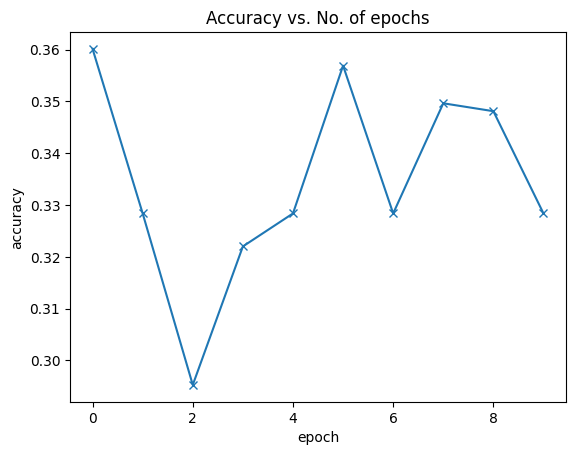

In [165]:
plot_accuracies(all_losses)

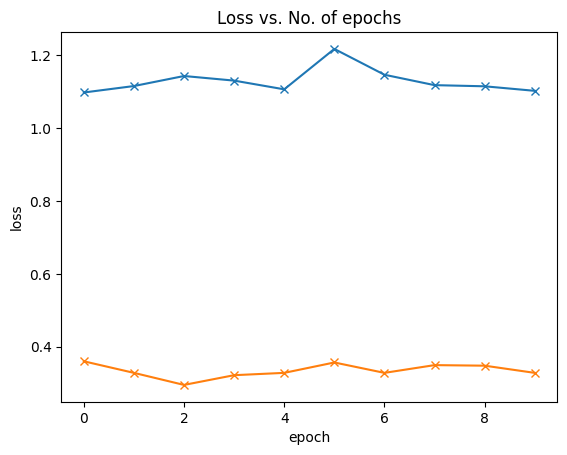

In [166]:
plot_losses(all_losses)